In [1]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.integrate import odeint
import seaborn as sns

colors=sns.color_palette("Set2")
sns.palplot(sns.color_palette("Set2"))

# Figure Size Setting
def set_fig_size(fig_width_pt,nrow=1,ncol=1):
    #Ysize_over_Xsize=(np.sqrt(5)-1)/2
    Ysize_over_Xsize=3/4

    fig_width_in = fig_width_pt/72.27
    
    fig_height_in=fig_width_in*Ysize_over_Xsize*(nrow/ncol)
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim

# these numbers come from the latex document
# using the commands 
#\showthe\columnwidth
# \showthe\textwidth
colwidth=229.5
textwidth=469


%matplotlib inline

# FIGURE STYLING
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.linewidth'] = 0.5 
mpl.rcParams['xtick.major.size'] = 3
mpl.rcParams['ytick.major.size'] = 3

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

mpl.rcParams['xtick.minor.size']=0
mpl.rcParams['ytick.minor.size']=0


mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
# definiting functions for numerical as well as approximation
def NumericalApprox(S,pars):
    k1, k2, k3, k4, k5, k6, XT, YT = pars
    r1 = k1*S+k2
    r2 = k3+k4+k6*XT
    r3=(k5-k6)*k1*S*XT/(k1*S+k2)
    tau = 1/r1 + 1/(r2+r3) - 1/(r1+r2)
    return tau

def getXassYass(S,pars):
    k1, k2, k3, k4, k5, k6, XT, YT = pars
    Xass = k1*S*XT/(k1*S+k2)
    YassNum=(k3+k5*Xass)*YT
    YassDen=k3+k4+k6*XT+(k5-k6)*Xass
    Yass=YassNum/YassDen
    return Xass, Yass


def getExtendedODE(X, t, S, pars):
    k1, k2, k3, k4, k5, k6, XT, YT = pars
    Xa, Ya, z1, z2, z3 = X
    Xass, Yass = getXassYass(S, pars)
    dX=np.zeros(len(X))
    dX[0] = k1*S*XT - (k1*S + k2)*Xa
    dX[1] = k3*YT + k5*YT*Xa - (k3+k4+k6*XT)*Ya - (k5-k6)*Xa*Ya
    dX[2] = Yass - Ya
    dX[3] = 1
    dX[4] = z2*(Yass - Ya)
    return dX


def getExtendedIC(pars):
    k1, k2, k3, k4, k5, k6, XT, YT = pars
    Xa0 = 0
    Ya0 = k3*YT/(k3+k4+k6*XT)
    z10 = 0
    z20 = 0
    z30 = 0
    return [Xa0, Ya0, z10, z20, z30]

# Panel A of the figure
In the limiting case when the receptor dynamics equilibriates instantaneously, we have that the response time of the receptor is given by
\begin{equation}
\mathcal{T}_{Y^{*}} \approx \frac{1}{k_3 + k_4 + k_5 \frac{k_1 S X_T}{k_1 S + k_2} + k_6 \frac{k_2 X_T}{k_1 S + k_2}}
\end{equation}

Re-arranging terms, we obtain that
\begin{equation}
\mathcal{T}_{Y^{*}} \approx \frac{\frac{S}{k_3 + k_4 + k_5 X_T} + \frac{k_2}{k_1(k_3 + k_4 + k_5 X_T)}}{S + \frac{k_2}{k_1}\frac{k_3 + k_4 + k_6 X_T}{k_3 + k_4 + k_5 X_T}}.
\end{equation}

This is a classical dose response curve! It has the same EC50 as $\Theta_{Y^{*}}$.

At $S=0$, the timescale is 
\begin{equation}
\mathcal{T}_0 = \frac{1}{k_3 + k_4 + k_6 X_T}.
\end{equation}


At $S>>\Theta_{Y^{*}}$, we obtain
\begin{equation}
\mathcal{T}_{\infty} = \frac{1}{k_3 + k_4 + k_5 X_T}.
\end{equation}

For concerted model, these two are exactly same! So there is no dose response dependency.


** HOW DO WE MAKE PLOTS**

- Our x-axis variable is $k_1 S / k_2$, which is stimulus/binding affinity.
- We keep same $k_1 S / k_2$ as we vary $k_1 S / k_2$.
- Suppose $s = k_1 S / k_2$. Then $k_1 S + k_2 = k_2 (1+s)$.
- We know the response time at EC50. Let us make sure that $k_2 (1+s)$ is much greater than that. To this end, we assume that $k_2 (1+s) = \frac{1}{2} \left(\frac{1}{k_3 + k_4 + k_6 X_T}+\frac{1}{k_3 + k_4 + k_5 X_T}\right)$. Thus for a given $s$, we can compute $k_2$.
- Just to keep things simple, we assume same initial condition.

In [3]:
sList = np.logspace(-3,3,101)

# parameters for activation (fig 3a)


TyActivationDR=[]
TyActivationDR_norm=[]
TyActivationDR_Approx_norm=[]

for s in sList:
    XT=100
    YT=100
    k3=1
    k4=9
    k5=90/XT
    k6=0
    Sact=1
    Ty0=1/(k3+k4+k6*XT)
    Tyf=1/(k3+k4+k5*XT)
    k2=200/((1+s)*(Ty0+Tyf)) # this means that k2 (1+s) is like 100 times faster
    k1=k2*s/Sact
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,600,6001)
    sol_activation=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sact,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_activation[-1,4]/sol_activation[-1,2]
    TyActivationDR.append(val)
    TyActivationDR_norm.append(2*val/(Ty0+Tyf))
    approxval = (2/(Ty0+Tyf))*NumericalApprox(Sact,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyActivationDR_Approx_norm.append(approxval)

Act_EC50=(1+9)/(1+9+90) #(k3+k4+k6*XT)/(k3+k4+k5*XT)
    
    
TyDerepDR=[]
TyDerepDR_norm=[]
TyDerepDR_Approx_norm=[]

for s in sList:
    XT=100
    YT=100
    k3=10
    k4=0
    k5=0
    k6=90/XT
    Sderep=1
    Ty0=1/(k3+k4+k6*XT)
    Tyf=1/(k3+k4+k5*XT)
    k2=200/((1+s)*(Ty0+Tyf)) # this means that k2 (1+s) is like 100 times faster
    k1=k2*s/Sderep
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,600,6001)
    sol_derep=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sderep,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_derep[-1,4]/sol_derep[-1,2]
    TyDerepDR.append(val)
    TyDerepDR_norm.append(2*val/(Ty0+Tyf))
    approxval = (2/(Ty0+Tyf))*NumericalApprox(Sderep,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyDerepDR_Approx_norm.append(approxval)

Derep_EC50=(10+90)/(10) #(k3+k4+k6*XT)/(k3+k4+k5*XT)


TyConcDR=[]
TyConcDR_norm=[]
TyConcDR_Approx_norm=[]


for s in sList:
    XT=100
    YT=100
    k3=10
    k4=0
    k5=90/XT
    k6=90/XT
    Sconc=1
    Ty0=1/(k3+k4+k6*XT)
    Tyf=1/(k3+k4+k5*XT)
    k2=200/((1+s)*(Ty0+Tyf)) # this means that k2 (1+s) is like 100 times faster
    k1=k2*s/Sconc
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,1000,10001)
    sol_conc=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sconc,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_conc[-1,4]/sol_conc[-1,2]
    TyConcDR.append(val)
    TyConcDR_norm.append(2*val/(Ty0+Tyf))
    approxval = (2/(Ty0+Tyf))*NumericalApprox(Sconc,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyConcDR_Approx_norm.append(approxval)

C:\Users\khemr\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [4]:
ratioList=np.logspace(-1.5,1,101) # this is the ratio of receptor response time to basal response time, which is k3+k4+k6XT


TyActivationRatioList=[]
TyActivationRatioList_norm=[]
TyActivationRatioList_Approx_norm=[]


for r in ratioList:
    XT=100
    YT=100
    k3=1/9
    k4=1
    k5=10/XT
    k6=0
    Sact=1
    s=1
    k2=(k3+k4+k6*XT)/((1+s)*r) # this maintains the same steady-state
    k1=k2*s/Sact
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,600,6001)
    sol_activation=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sact,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_activation[-1,4]/sol_activation[-1,2]
    TyActivationRatioList.append(val)
    TyActivationRatioList_norm.append(val*(k3+k4+k6*XT))
    approxval = (k3+k4+k6*XT)*NumericalApprox(Sact,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyActivationRatioList_Approx_norm.append(approxval)

    
    
TyDerepRatioList=[]
TyDerepRatioList_norm=[]
TyDerepRatioList_Approx_norm=[]


for r in ratioList:
    XT=100
    YT=100
    k3=1/9
    k4=0
    k5=0
    k6=1/XT
    Sderep=1
    s=1
    k2=(k3+k4+k6*XT)/((1+s)*r) # this maintains the same steady-state
    k1=k2*s/Sact
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,600,6001)
    sol_derep=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sderep,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_derep[-1,4]/sol_derep[-1,2]
    TyDerepRatioList.append(val)
    TyDerepRatioList_norm.append(val*(k3+k4+k6*XT))
    approxval = (k3+k4+k6*XT)*NumericalApprox(Sderep,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyDerepRatioList_Approx_norm.append(approxval)


TyConcRatioList=[]
TyConcRatioList_norm=[]
TyConcRatioList_Approx_norm=[]

for r in ratioList:
    XT=100
    YT=100
    k3=1/9
    k4=0
    k5=1/XT
    k6=1/XT
    Sconc=1
    s=1
    k2=(k3+k4+k6*XT)/((1+s)*r) # this maintains the same steady-state
    k1=k2*s/Sact
    ICext=getExtendedIC([k1, k2, k3, k4, k5, k6, XT, YT])
    time=np.linspace(0,600,60001)
    sol_conc=sp.integrate.odeint(getExtendedODE,ICext, time, args=(Sconc,[k1, k2, k3, k4, k5, k6, XT, YT]),rtol='1e-12')
    val=sol_conc[-1,4]/sol_conc[-1,2]
    TyConcRatioList.append(val)
    TyConcRatioList_norm.append(val*(k3+k4+k6*XT))
    approxval = (k3+k4+k6*XT)*NumericalApprox(Sconc,[k1, k2, k3, k4, k5, k6, XT, YT])
    TyConcRatioList_Approx_norm.append(approxval)

# Plotting the data

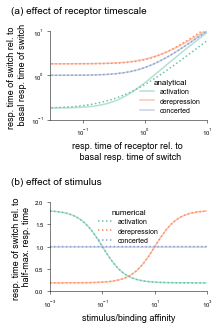

In [5]:
# Plotting together
fig=plt.figure(figsize=set_fig_size(colwidth,2,1))

gs = mpl.gridspec.GridSpec(2,1)

A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[1,0])



# analytical
A.loglog(ratioList,TyActivationRatioList_Approx_norm,color=colors[0],alpha=0.5,label='activation')
A.loglog(ratioList,TyDerepRatioList_Approx_norm,color=colors[1],alpha=0.5,label='derepression')
A.loglog(ratioList,TyConcRatioList_Approx_norm,color=colors[2],alpha=0.5,label='concerted')


# numerical
A.loglog(ratioList,TyActivationRatioList_norm,':',color=colors[0])
A.loglog(ratioList,TyDerepRatioList_norm,':',color=colors[1])
A.loglog(ratioList,TyConcRatioList_norm,':',color=colors[2])


A.set_xticks([1e-1, 1e0, 1e1])
A.set_yticks([1e-1, 1e0, 1e1])
A.set_ylim(1e-1,1e1)
A.set_xlim(0.03,1e1)

A.set_xlabel('resp. time of receptor rel. to \n basal resp. time of switch')
A.set_ylabel('resp. time of switch rel. to \n basal resp. time of switch')
A.text(-0.25,1.2,'(a) effect of receptor timescale',transform=A.transAxes,fontsize=10)


legend1=A.legend(loc='best',title='analytical',frameon=False,fontsize=7)

title1 = legend1.get_title()
title1.set_fontsize(8)




#analytical
B.semilogx(sList,TyActivationDR_Approx_norm,color=colors[0],alpha=0.5)
B.semilogx(sList,TyDerepDR_Approx_norm,color=colors[1],alpha=0.5)
B.semilogx(sList,TyConcDR_Approx_norm,color=colors[2],alpha=0.5)

# numerical
B.semilogx(sList,TyActivationDR_norm,':',color=colors[0],label='activation')
B.semilogx(sList,TyDerepDR_norm,':',color=colors[1],label='derepression')
B.semilogx(sList,TyConcDR_norm,':',color=colors[2],label='concerted')

legend2=B.legend(loc='upper center',title='numerical',frameon=False,fontsize=7)

title2 = legend2.get_title()
title2.set_fontsize(8)


B.set_xticks([1e-3, 1e-1, 1e1, 1e3])
B.set_yticks([0, 0.5, 1, 1.5, 2])
B.set_ylim(0,2)
B.set_xlim(1e-3,1e3)

B.set_xlabel('stimulus/binding affinity')
B.set_ylabel('resp. time of switch rel. to \n half-max. resp. time')
B.text(-0.25,1.2,'(b) effect of stimulus',transform=B.transAxes,fontsize=10)


gs.tight_layout(fig)
#plt.savefig('../fig_pdfs_for_paper/fig3v1.pdf',bbox_inches = 'tight', pad_inches = 0)

## ANOTHER VERSION OF THE FIGURE, WHERE WE SCALE THE X-AXIS by EC50 INSTEAD

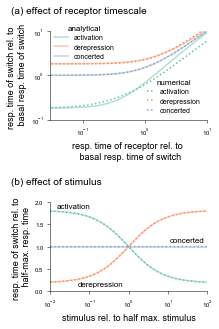

In [6]:
# Plotting together
fig=plt.figure(figsize=set_fig_size(colwidth,2,1))

gs = mpl.gridspec.GridSpec(2,1)

A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[1,0])



# analytical
A.loglog(ratioList,TyActivationRatioList_Approx_norm,color=colors[0],alpha=0.5,label='activation')
A.loglog(ratioList,TyDerepRatioList_Approx_norm,color=colors[1],alpha=0.5,label='derepression')
A.loglog(ratioList,TyConcRatioList_Approx_norm,color=colors[2],alpha=0.5,label='concerted')


# numerical
TyactNum,=A.loglog(ratioList,TyActivationRatioList_norm,':',color=colors[0])
TyDerepNum,=A.loglog(ratioList,TyDerepRatioList_norm,':',color=colors[1])
TyConcNum,=A.loglog(ratioList,TyConcRatioList_norm,':',color=colors[2])


A.set_xticks([1e-1, 1e0, 1e1])
A.set_yticks([1e-1, 1e0, 1e1])
A.set_ylim(1e-1,1e1)
A.set_xlim(0.03,1e1)

A.set_xlabel('resp. time of receptor rel. to \n basal resp. time of switch')
A.set_ylabel('resp. time of switch rel. to \n basal resp. time of switch')
A.text(-0.25,1.2,'(a) effect of receptor timescale',transform=A.transAxes,fontsize=10)


legend1=A.legend(loc=(1e-2,65e-2),title='analytical',frameon=False,fontsize=7)

title1 = legend1.get_title()
title1.set_fontsize(8)

legend2=A.legend([TyactNum,TyDerepNum,TyConcNum,],['activation','derepression','concerted'], 
                  title='numerical',fontsize=7,frameon=False,handlelength=1,loc='lower right')

title2 = legend2.get_title()
title2.set_fontsize(8)

#legend2lw=legend2.get_lines()
#legend2lw[0].set_linewidth(2)
#legend2lw[1].set_linewidth(2)
#legend2lw[2].set_linewidth(2)


A.add_artist(legend1)


snormActList=[s/Act_EC50 for s in sList]
snormDerepList=[s/Derep_EC50 for s in sList]
snormConcList=[s for s in sList]
# note that sList and snormConcList are same


#analytical
B.semilogx(snormActList,TyActivationDR_Approx_norm,color=colors[0],alpha=0.5)
B.semilogx(snormDerepList,TyDerepDR_Approx_norm,color=colors[1],alpha=0.5)
B.semilogx(snormConcList,TyConcDR_Approx_norm,color=colors[2],alpha=0.5)

# numerical
B.semilogx(snormActList,TyActivationDR_norm,':',color=colors[0],label='activation')
B.semilogx(snormDerepList,TyDerepDR_norm,':',color=colors[1],label='derepression')
B.semilogx(snormConcList,TyConcDR_norm,':',color=colors[2],label='concerted')

#legend2=B.legend(loc='upper left',title='numerical',frameon=False,fontsize=7)

#title2 = legend2.get_title()
#title2.set_fontsize(8)

B.text(1.5e-2,1.88,'activation',fontsize=8)
B.text(5e-2,0.12,'derepression',fontsize=8)
B.text(1.1e1,1.1,'concerted',fontsize=8)


B.set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2])
B.set_yticks([0, 0.5, 1, 1.5, 2])
B.set_ylim(0,2)
B.set_xlim(1e-2,1e2)
B.set_xlabel('stimulus rel. to half max. stimulus')
B.set_ylabel('resp. time of switch rel. to \n half-max. resp. time')
B.text(-0.25,1.2,'(b) effect of stimulus',transform=B.transAxes,fontsize=10)


gs.tight_layout(fig)
#plt.savefig('../fig_pdfs_for_paper/fig3v2.pdf',bbox_inches = 'tight', pad_inches = 0)

# FINAL FIGURE 3

In [7]:
def pulseONXY(X, t,pars):
    k1, k2, k3, k4, k5, k6, XT, YT, S = pars
    dX = np.zeros(len(X))
    Xa, Ya = X
    dX[0] = k1*S*(XT-Xa) - k2*Xa
    dX[1] = (k3+k5*Xa)*(YT-Ya) - (k4+k6*(XT-Xa))*Ya
    return dX

def pulseOFFXY(X, t,pars):
    k1, k2, k3, k4, k5, k6, XT, YT, S = pars
    Xa, Ya  = X
    dX = np.zeros(len(X))
    dX[0] = - k2*Xa
    dX[1] = (k3+k5*Xa)*(YT-Ya) - (k4+k6*(XT-Xa))*Ya
    return dX


def solODEPulseXY(k1, k2, k3, k4, k5, k6, XT, YT, S, Ton, Toff, tmax):
    num_of_pulses = numPulses(Ton,Toff,tmax)
    
    X0Y0min=np.zeros((num_of_pulses,2))
    X0Y0min[0,1]=k3*YT/(k3+k4+k6*XT)
    
    X0Y0max=np.zeros((num_of_pulses,2))
    
    tsol=np.array([0])
    xsol=X0Y0min[0,:]
    Ssol=np.array([0])
    
    for idx in range(0,num_of_pulses):
        tstart=idx*(Ton+Toff)
        t_during_ON = np.linspace(0,Ton,1001)
        t_during_OFF = np.linspace(0,Toff,1001)
        Stimulus_during_ON=S*np.ones(len(t_during_ON))
        Stimulus_during_OFF=np.zeros(len(t_during_ON))

        
        sol_during_ON = sp.integrate.odeint(pulseONXY,X0Y0min[idx],t_during_ON,
                                            args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
        t_shifted_ON = tstart*np.ones(len(t_during_ON)) + t_during_ON
        X0Y0max[idx]=sol_during_ON[-1]
        
        
        sol_during_OFF = sp.integrate.odeint(pulseOFFXY,X0Y0max[idx],t_during_OFF,
                                             args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
        t_shifted_OFF = (tstart+Ton)*np.ones(len(t_during_OFF)) + t_during_OFF
        if idx<num_of_pulses-1:
            X0Y0min[idx+1] = sol_during_OFF[-1]
            
        
        tsol = np.concatenate((tsol,t_shifted_ON[1:], t_shifted_OFF[1:]))
        xsol = np.vstack((xsol,sol_during_ON[1:,:], sol_during_OFF[1:,:]))
        Ssol = np.concatenate((Ssol,Stimulus_during_ON[1:], Stimulus_during_OFF[1:]))
    
    return tsol,xsol,Ssol


def getXssYss(k1, k2, k3, k4, k5, k6, XT, YT, S):
    numXss=k1*S*XT
    denXss=k1*S+k2
    Xss=numXss/denXss
    
    numYss=(k3+k5*Xss)*YT
    denYss=k3+k4+k5*Xss+k6*(XT-Xss)
    Yss=numYss/denYss
    return Xss,Yss



def solXYODEConstant(k1, k2, k3, k4, k5, k6, XT, YT, S, Ton, Toff, tmax):
    tvals=np.linspace(0,tmax,1001)
    sol=sp.integrate.odeint(pulseONXY,[0,k3*YT/(k3+k4+k6*XT)],tvals,args=([k1, k2, k3, k4, k5, k6, XT, YT, S],),mxstep=100000)
    return tvals,sol


def numPulses(Ton,Toff,tmax):
    return np.ceil(tmax/(Ton+Toff)).astype('int')



# Fig 3C
# activation
k1=1
k2=1
k3a=1/9
k4a=1
k5a=0.1
k6a=0
XT=100
YT=100
Sa=0.1

Ton=20
Toff=10
tmax=Ton+Toff

XssAct,YssAct = getXssYss(k1, k2, k3a, k4a, k5a, k6a, XT, YT, Sa)

tbasalAct=k3a+k4a+k6a*XT



# derepression

k1=1
k2=1
k3r=1/9
k4r=0
k5r=0
k6r=80/8100
XT=100
YT=100
Sr=10

XssR,YssR = getXssYss(k1, k2, k3r, k4r, k5r, k6r, XT, YT, Sr)

tbasalRep=k3r+k4r+k6r*XT


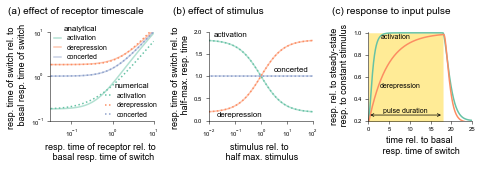

In [8]:
# Plotting together
fig=plt.figure(figsize=(469/72.27/0.95,469/72.27/2.5))

gs = mpl.gridspec.GridSpec(1,3)

A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])



# analytical
A.loglog(ratioList,TyActivationRatioList_Approx_norm,color=colors[0],alpha=0.5,label='activation')
A.loglog(ratioList,TyDerepRatioList_Approx_norm,color=colors[1],alpha=0.5,label='derepression')
A.loglog(ratioList,TyConcRatioList_Approx_norm,color=colors[2],alpha=0.5,label='concerted')


# numerical
TyactNum,=A.loglog(ratioList,TyActivationRatioList_norm,':',color=colors[0])
TyDerepNum,=A.loglog(ratioList,TyDerepRatioList_norm,':',color=colors[1])
TyConcNum,=A.loglog(ratioList,TyConcRatioList_norm,':',color=colors[2])


A.set_xticks([1e-1, 1e0, 1e1])
A.set_yticks([1e-1, 1e0, 1e1])
A.set_ylim(1e-1,1e1)
A.set_xlim(0.03,1e1)

A.set_xlabel('resp. time of receptor rel. to \n basal resp. time of switch')
A.set_ylabel('resp. time of switch rel. to \n basal resp. time of switch')
A.text(-0.4,1.2,'(a) effect of receptor timescale',transform=A.transAxes,fontsize=10)


legend1=A.legend(loc=(1e-2,65e-2),title='analytical',frameon=False,handlelength=1,fontsize=7)

title1 = legend1.get_title()
title1.set_fontsize(8)

legend2=A.legend([TyactNum,TyDerepNum,TyConcNum,],['activation','derepression','concerted'], 
                  title='numerical',fontsize=7,frameon=False,handlelength=1,loc=(0.5,0))

title2 = legend2.get_title()
title2.set_fontsize(8)

#legend2lw=legend2.get_lines()
#legend2lw[0].set_linewidth(2)
#legend2lw[1].set_linewidth(2)
#legend2lw[2].set_linewidth(2)


A.add_artist(legend1)


snormActList=[s/Act_EC50 for s in sList]
snormDerepList=[s/Derep_EC50 for s in sList]
snormConcList=[s for s in sList]
# note that sList and snormConcList are same


#analytical
B.semilogx(snormActList,TyActivationDR_Approx_norm,color=colors[0],alpha=0.5)
B.semilogx(snormDerepList,TyDerepDR_Approx_norm,color=colors[1],alpha=0.5)
B.semilogx(snormConcList,TyConcDR_Approx_norm,color=colors[2],alpha=0.5)

# numerical
B.semilogx(snormActList,TyActivationDR_norm,':',color=colors[0],label='activation')
B.semilogx(snormDerepList,TyDerepDR_norm,':',color=colors[1],label='derepression')
B.semilogx(snormConcList,TyConcDR_norm,':',color=colors[2],label='concerted')

#legend2=B.legend(loc='upper left',title='numerical',frameon=False,fontsize=7)

#title2 = legend2.get_title()
#title2.set_fontsize(8)

B.text(1.5e-2,1.88,'activation',fontsize=8)
B.text(2e-2,0.08,'derepression',fontsize=8)
B.text(3e0,1.1,'concerted',fontsize=8)


B.set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2])
B.set_yticks([0, 0.5, 1, 1.5, 2])
B.set_ylim(0,2)
B.set_xlim(1e-2,1e2)
B.set_xlabel('stimulus rel. to \n half max. stimulus')
B.set_ylabel('resp. time of switch rel. to \n half-max. resp. time')
B.text(-0.35,1.2,'(b) effect of stimulus',transform=B.transAxes,fontsize=10)




tsol_act_Slow,xsol_act_Slow,Ssol_act_Slow=solODEPulseXY(k1, k2, k3a, k4a, k5a, k6a, XT, YT, Sa, Ton, Toff, tmax)
#plt.plot(tsol_act_Slow,xsol_act_Slow[:,0]/XssAct,color='k',alpha=0.5,linestyle='--')
tsol_rep_Slow,xsol_rep_Slow,Ssol_rep_Slow=solODEPulseXY(k1, k2, k3r, k4r, k5r, k6r, XT, YT, Sr, Ton, Toff, tmax)
#plt.plot(tsol_rep_Slow,xsol_rep_Slow[:,0]/XssR,color='k',alpha=0.5,linestyle='--')
#plt.plot(tsol_rep_Slow,xsol_rep_Slow[:,1]/YssR,color=colors[1],label='derepression')

C.plot(tsol_act_Slow/tbasalAct,xsol_act_Slow[:,1]/YssAct,color=colors[0],label='activation')
C.plot(tsol_rep_Slow/tbasalRep,xsol_rep_Slow[:,1]/YssR,color=colors[1],label='derepression')
C.fill_between(tsol_act_Slow/tbasalAct,10*Ssol_act_Slow,color=colors[5],linewidth=0.1,alpha=0.5)

C.set_xlim(0,25)
C.set_ylim(0.2,1.01)

C.set_xlabel('time rel. to basal \n resp. time of switch')
C.set_ylabel('resp. rel. to steady-state\n resp. to constant stimulus')
C.text(-0.35,1.2,'(c) response to input pulse',transform=C.transAxes,fontsize=10)

C.annotate('',
            xy=(0,0.25), size=7, xycoords='data',
            xytext=(20/tbasalAct, 0.25), textcoords='data',
            arrowprops=dict(arrowstyle="<->",lw=0.7))
C.text(4/tbasalAct,0.27,'pulse duration',fontsize=7)
C.text(2.8,0.5,'derepression',fontsize=7)
C.text(3,0.95,'activation',fontsize=7)


gs.tight_layout(fig)
plt.savefig('../fig_pdfs_for_paper/fig3.pdf',bbox_inches = 'tight', pad_inches = 0)

##### 